# Reference Solution for Assignment 2

## Import cats-vs-dogs kaggle competition Dataset   

In [ ]:
# ! pip install -q kaggle
# click 'create new token' in this website: https://www.kaggle.com/settings
# Save the json file to local computer and then upload by following commands to current notebook workspace:

In [ ]:
from google.colab import files
files.upload()

In [2]:
# !rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Accept rules in their website: https://www.kaggle.com/c/dogs-vs-cats/rules

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:35<00:00, 25.3MB/s]
100% 812M/812M [00:35<00:00, 23.7MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

!unzip -qq train.zip

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

# For questions 1-3, we will implement steps a, b and c

## a. Adjust the training set size according to the requirements of questions 1-3

1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

In [ ]:
# # remove previous folder
# import os, shutil
# shutil.rmtree(pathlib.Path("cats_vs_dogs"))

In [6]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

In [ ]:
# remove previous folder
import os, shutil
shutil.rmtree(pathlib.Path("cats_vs_dogs"))

In [ ]:
make_subset("train", start_index=0, end_index=3000) # 3000 training set
make_subset("validation", start_index=3000, end_index=3500) # 500 validation set
make_subset("test", start_index=3500, end_index=4000) # 500 test set

3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

In [ ]:
# remove previous folder
import os, shutil
shutil.rmtree(pathlib.Path("cats_vs_dogs_small"))

In [ ]:
make_subset("train", start_index=0, end_index=6000) # 6000 training set
make_subset("validation", start_index=6000, end_index=6500) # 500 validation set
make_subset("test", start_index=6500, end_index=7000) # 500 test set

More extremely, use the complete dataset: increase the training size to 11500

In [ ]:
make_subset("train", start_index=0, end_index=11500) # 115000 training set
make_subset("validation", start_index=11500, end_index=12000) # 500 validation set
make_subset("test", start_index=12000, end_index=12500) # 500 test set

## b. Convert image data into processed tensor data

In [7]:
# read picture data
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    # Decode jpeg content to RGB grids of pixels. Each pixel value will be between 0 and 255. RGB 3 colors
    batch_size=32) # data batch shape:(32, 180, 180, 3), label batch shape: 32

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)
# After pre-processing, our input tensor has shape (180, 180, 3)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## c. Building the model with data augmentation and dropout

**Define a data augmentation stage to add to an image model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images that go through it
        layers.RandomRotation(0.1), # Rotates the input images by a random value in the range [–10%, +10%] (these are fractions of a full circle—in degrees, the range would be [–36 degrees, +36 degrees])
        layers.RandomZoom(0.2), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
    ]
)

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x) # the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only remix existing information.
# As such, this may not be enough to completely get rid of overfitting.
# To further fight overfitting, we’ll also add a Dropout layer to our model right before the densely connected classifier.
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100, # Because we expect overfitting to occur much later during training, we will train for three times as many epochs—one hundred.
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 4s 21ms/step - loss: 0.6975 - accuracy: 0.5142 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 2/100
125/125 [==============================] - 2s 19ms/step - loss: 0.6911 - accuracy: 0.5435 - val_loss: 0.7130 - val_accuracy: 0.5040
Epoch 3/100
125/125 [==============================] - 2s 19ms/step - loss: 0.6709 - accuracy: 0.6003 - val_loss: 0.6398 - val_accuracy: 0.6310
Epoch 4/100
125/125 [==============================] - 3s 20ms/step - loss: 0.6388 - accuracy: 0.6367 - val_loss: 0.5997 - val_accuracy: 0.6740
Epoch 5/100
125/125 [==============================] - 3s 20ms/step - loss: 0.6030 - accuracy: 0.6752 - val_loss: 0.5723 - val_accuracy: 0.7160
Epoch 6/100
125/125 [==============================] - 3s 20ms/step - loss: 0.5850 - accuracy: 0.6948 - val_loss: 0.5888 - val_accuracy: 0.6860
Epoch 7/100
125/125 [==============================] - 3s 19ms/step - loss: 0.5571 - accuracy: 0.7095 - val_loss: 0.5565 - val_accuracy:

**Evaluating the model on the test set**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

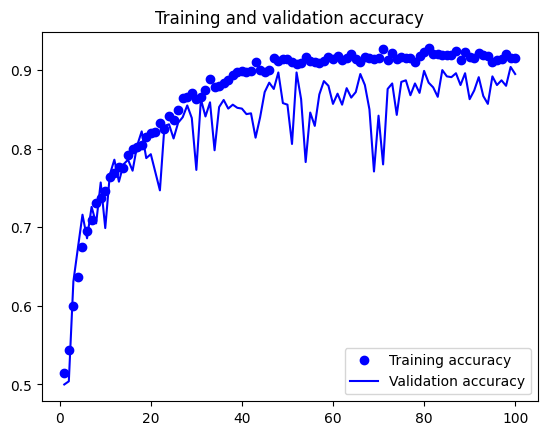

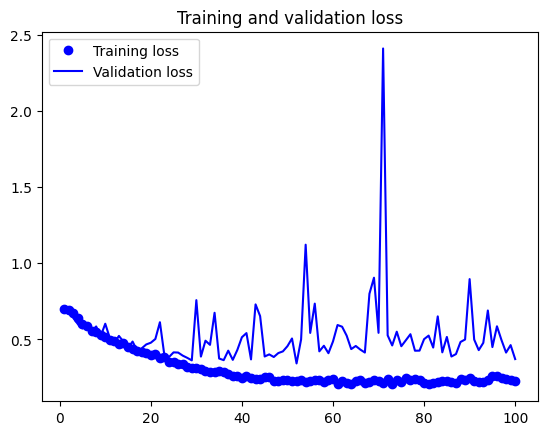

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
# plt.savefig('initial_plot_accuracy_p1_1.png')
# plt.savefig('initial_plot_accuracy_p2_1.png')
# plt.savefig('initial_plot_accuracy_p3_1.png')

from google.colab import files
# files.download("initial_plot_accuracy_p1_1.png")
# files.download("initial_plot_accuracy_p2_1.png")
# files.download("initial_plot_accuracy_p3_1.png")

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
# plt.show()
# plt.savefig('initial_plot_loss_p1_1.png')
# plt.savefig('initial_plot_loss_p2_1.png')
# plt.savefig('initial_plot_loss_p3_1.png')

from google.colab import files
# files.download("initial_plot_loss_p1_1.png")
# files.download("initial_plot_loss_p2_1.png")
# files.download("initial_plot_loss_p3_1.png")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}, Test loss: {test_loss:.3f}")

32/32 [==============================] - 1s 9ms/step - loss: 0.3163 - accuracy: 0.9080
Test accuracy: 0.908, Test loss: 0.316


In [ ]:
import pandas as pd
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
df0 = pd.DataFrame({'epochs': epochs, 'model': ["inital_model"]*len(loss), 'loss_values': loss, 'val_loss_values': val_loss, 'acc': accuracy, 'val_acc': val_accuracy, 'test_loss': test_loss, 'test_acc': test_acc})
# df0.to_csv('df_augment_p1_1.csv')
# df0.to_csv('df_augment_p2_1.csv')
# df0.to_csv('df_augment_p3_1.csv')

from google.colab import files
# files.download("df_augment_p1_1.csv")
# files.download("df_augment_p2_1.csv")
# files.download("df_augment_p3_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

Increasing the training set size generally does not hurt an algorithm's performance, and it may help significantly.
For example, increasing the training set size from 3,000 to 6,000 significantly improved the test accuracy from 0.885 to 0.923. However, increasing the training set size from 6,000 to 115,000 only slightly improved the test accuracy by around 1%.

# For question 4, we'll implement steps a, b, d and e

4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Use a pretrained model for question 4

### d. Feature extraction with a pretrained model with data augmentation and dropout layers

**Instantiating the VGG16 convolutional base**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Extracting the VGG16 features and corresponding labels**

In [10]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


In [11]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 19ms/step


**Instantiating and freezing the VGG16 convolutional base**

In [12]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Adding a data augmentation stage and a classifier to the convolutional base**

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(
     lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 12s 144ms/step - loss: 22.1873 - accuracy: 0.8945 - val_loss: 3.9862 - val_accuracy: 0.9750
Epoch 2/50
63/63 [==============================] - 9s 136ms/step - loss: 6.9458 - accuracy: 0.9375 - val_loss: 5.6310 - val_accuracy: 0.9640
Epoch 3/50
63/63 [==============================] - 9s 146ms/step - loss: 6.7177 - accuracy: 0.9540 - val_loss: 3.6221 - val_accuracy: 0.9710
Epoch 4/50
63/63 [==============================] - 9s 138ms/step - loss: 5.3179 - accuracy: 0.9535 - val_loss: 7.5028 - val_accuracy: 0.9580
Epoch 5/50
63/63 [==============================] - 9s 138ms/step - loss: 2.8284 - accuracy: 0.9720 - val_loss: 6.5917 - val_accuracy: 0.9720
Epoch 6/50
63/63 [==============================] - 9s 137ms/step - loss: 3.7806 - accuracy: 0.9680 - val_loss: 4.7499 - val_accuracy: 0.9670
Epoch 7/50
63/63 [==============================] - 9s 143ms/step - loss: 2.8969 - accuracy: 0.9700 - val_loss: 2.8396 - val_accuracy: 0.9780
Epoc

**Evaluating the model on the test set**

In [15]:
# deserialize lambda layers. https://github.com/keras-team/tf-keras/issues/44
from keras.src.saving import serialization_lib
serialization_lib.enable_unsafe_deserialization()

In [16]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 86ms/step - loss: 1.7860 - accuracy: 0.9770
Test accuracy: 0.977


### e. Fine-tuning a pretrained model

**Freezing all layers until the fourth from the last**

In [17]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 162ms/step - loss: 0.4295 - accuracy: 0.9885 - val_loss: 1.5337 - val_accuracy: 0.9820
Epoch 2/30
63/63 [==============================] - 9s 150ms/step - loss: 0.2728 - accuracy: 0.9915 - val_loss: 1.7804 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 10s 160ms/step - loss: 0.4484 - accuracy: 0.9900 - val_loss: 1.4581 - val_accuracy: 0.9800
Epoch 4/30
63/63 [==============================] - 10s 151ms/step - loss: 0.2512 - accuracy: 0.9900 - val_loss: 1.4600 - val_accuracy: 0.9770
Epoch 5/30
63/63 [==============================] - 10s 158ms/step - loss: 0.1047 - accuracy: 0.9955 - val_loss: 1.2762 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 9s 149ms/step - loss: 0.3575 - accuracy: 0.9905 - val_loss: 1.5337 - val_accuracy: 0.9770
Epoch 7/30
63/63 [==============================] - 9s 148ms/step - loss: 0.1922 - accuracy: 0.9955 - val_loss: 1.7315 - val_accuracy: 0.9790
Ep

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.2363 - accuracy: 0.9810
Test accuracy: 0.981


## Conclusion.     
Increasing the training set size for the pretrained model didn't make much difference; the improvement in test set accuracy was less than 1%.